In [2]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [3]:
# Create list of all targets (minus background noise)
dataset_path = 'C:\\Users\Greg\ML\Technical'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['six', 'stop', 'three', 'tree']


In [7]:
# Settings
feature_sets_path = 'C:\\Users\\Greg\ML\\tflite-speech-recognition-master\\tflite-speech-recognition-master'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [8]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [9]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [10]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(9775, 16, 16)
(1212, 16, 16)
(1216, 16, 16)


In [11]:
# Peek at labels
print(y_val)

[2. 0. 0. ... 0. 0. 1.]


In [12]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [13]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 1.]


In [14]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.31435643564356436
0.6856435643564356


In [15]:
# View the dimensions of our input data
print(x_train.shape)

(9775, 16, 16)


In [16]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(9775, 16, 16, 1)
(1212, 16, 16, 1)
(1216, 16, 16, 1)


In [17]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [18]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [20]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [21]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
98/98 [==============================] - 3s 18ms/step - loss: 0.2352 - acc: 0.9025 - val_loss: 0.0939 - val_acc: 0.9637
Epoch 2/30
98/98 [==============================] - 1s 14ms/step - loss: 0.1061 - acc: 0.9620 - val_loss: 0.0613 - val_acc: 0.9744
Epoch 3/30
98/98 [==============================] - 1s 15ms/step - loss: 0.0829 - acc: 0.9684 - val_loss: 0.0549 - val_acc: 0.9777
Epoch 4/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0695 - acc: 0.9740 - val_loss: 0.0584 - val_acc: 0.9761
Epoch 5/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0616 - acc: 0.9786 - val_loss: 0.0460 - val_acc: 0.9802
Epoch 6/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0534 - acc: 0.9805 - val_loss: 0.0444 - val_acc: 0.9802
Epoch 7/30
98/98 [==============================] - 1s 14ms/step - loss: 0.0502 - acc: 0.9821 - val_loss: 0.0444 - val_acc: 0.9851
Epoch 8/30
98/98 [==============================] - 1s 13ms/step - loss: 0.0511 - a

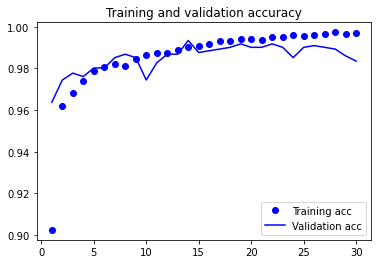

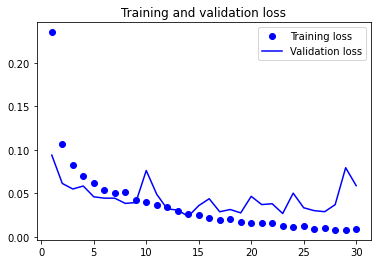

In [22]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# Save the model as a file
models.save_model(model, model_filename)

In [24]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

1
3
4
10
13
16
19
23
25
35
40
45
57
58
62
63
71
74
75
80
86
87
93
94
96
97
98
103
106
112
113
116
118
121
126
131
133
135
136
142
145
148
152
153
154
159
162
164
165
167
173
177
178
181
182
183
186
194
197
198
201
203
204
205
210
213
215
219
222
223
230
232
243
255
258
261
268
273
274
276
287
298
304
310
312
313
314
317
320
321
323
329
335
337
341
344
345
348
350
351
363
370
373
374
383
386
391
392
395
397
401
402
403
405
406
407
408
411
413
417
420
423
424
430
435
439
441
443
444
450
452
453
454
457
460
463
470
471
476
477
479
482
483
484
485
486
487
506
513
516
518
523
524
526
532
533
534
535
538
544
548
552
553
558
560
566
573
576
579
582
583
593
595
597
598
600
607
617
619
620
621
627
630
633
636
641
646
651
653
654
657
658
665
675
679
684
691
694
695
696
697
700
705
709
710
711
712
713
717
719
720
722
724
737
743
744
746
753
756
758
763
765
768
770
771
772
783
788
792
793
800
808
811
812
813
814
819
821
824
830
834
839
845
849
850
855
857
869
871
872
881
882
884
885
886
887
889
89

In [25]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 110ms/step
Answer: 0.0  Prediction: [[1.9180299e-15]]
1/1 [==============================] - 0s 16ms/step
Answer: 0.0  Prediction: [[1.3974461e-07]]
1/1 [==============================] - 0s 16ms/step
Answer: 0.0  Prediction: [[5.987292e-10]]
1/1 [==============================] - 0s 18ms/step
Answer: 1.0  Prediction: [[1.]]
1/1 [==============================] - 0s 21ms/step
Answer: 0.0  Prediction: [[4.204913e-13]]
1/1 [==============================] - 0s 20ms/step
Answer: 0.0  Prediction: [[1.1838766e-08]]
1/1 [==============================] - 0s 22ms/step
Answer: 1.0  Prediction: [[0.9999979]]
1/1 [==============================] - 0s 33ms/step
Answer: 0.0  Prediction: [[5.632022e-10]]
1/1 [==============================] - 0s 39ms/step
Answer: 0.0  Prediction: [[0.00020759]]
1/1 [==============================] - 0s 22ms/step
Answer: 0.0  Prediction: [[3.716415e-11]]


In [26]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

38/38 [==============================] - 0s 3ms/step - loss: 0.0938 - acc: 0.9803


[0.09376712888479233, 0.9802631735801697]